Importuri & configurări

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import shap
import joblib

from joblib import dump
from datetime import datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.calibration import calibration_curve
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, ConfusionMatrixDisplay,
    precision_recall_fscore_support, accuracy_score, brier_score_loss
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams["figure.dpi"] = 120

Încărcarea datelor

In [ ]:
from google.colab import files

uploaded = files.upload()
if not uploaded:
    raise RuntimeError("Nu s-a încărcat niciun fișier. Re-rulează și selectează 'diabetes.csv'.")

csv_file = list(uploaded.keys())[0]
print(f"\nFișier încărcat: {csv_file}\n")

df = pd.read_csv(csv_file)
print("Dimensiune dataset:", df.shape)
df.head()

Saving diabetes.csv to diabetes.csv

Fișier încărcat: diabetes.csv

Dimensiune dataset: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Info & statistici rapide

In [ ]:
print("Tipuri de date și non-null counts:")
display(df.info())

print("\nStatistici descriptive:")
display(df.describe())

suspect_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
print("\nZero-uri suspecte:")
for c in suspect_cols:
    if c in df.columns:
        print(f" - {c}: {(df[c]==0).sum()}")

print("\nDistribuția Outcome:")
display(df['Outcome'].value_counts().to_frame('count'))

Tipuri de date și non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None


Statistici descriptive:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



Zero-uri suspecte:
 - Glucose: 5
 - BloodPressure: 35
 - SkinThickness: 227
 - Insulin: 374
 - BMI: 11

Distribuția Outcome:


,count
Outcome,
0,500
1,268


Zero→NaN (col. clinice)

In [ ]:
cols_with_zeros = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
df_marked = df.copy()
df_marked[cols_with_zeros] = df_marked[cols_with_zeros].replace(0, np.nan)
df_marked.isna().sum()

,0
Pregnancies,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


Separare features/target + split train/test

In [ ]:
X = df_marked.drop(columns=["Outcome"])
y = df_marked["Outcome"].astype(int)
feature_names = X.columns.tolist()

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
X_train_raw.shape, X_test_raw.shape, y_train.mean(), y_test.mean()

((614, 8),
 (154, 8),
 np.float64(0.3485342019543974),
 np.float64(0.35064935064935066))

Imputare + Scalare (fit pe train, apply pe test)

In [ ]:
imputer = SimpleImputer(strategy="median")
scaler  = StandardScaler()

X_train_imp = imputer.fit_transform(X_train_raw)
X_test_imp  = imputer.transform(X_test_raw)

X_train_scl = scaler.fit_transform(X_train_imp)
X_test_scl  = scaler.transform(X_test_imp)

SMOTE pe train (echilibrare pentru varianta îmbunătățită)

In [ ]:
smote = SMOTE(random_state=RANDOM_STATE)
X_train_tr, y_train_tr = smote.fit_resample(X_train_scl, y_train)

print("Distribuție înainte SMOTE:", np.bincount(y_train))
print("Distribuție după SMOTE   :", np.bincount(y_train_tr))

Distribuție înainte SMOTE: [400 214]
Distribuție după SMOTE   : [400 400]


Utilitare (metrice & grafice comparative)

In [ ]:
def eval_binary(y_true, proba, threshold=0.5, title=""):
    pred = (proba >= threshold).astype(int)
    acc = accuracy_score(y_true, pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, pred, average="binary", zero_division=0)
    auc = roc_auc_score(y_true, proba)
    print(f"{title}\nAccuracy={acc:.4f}  Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}  AUC={auc:.4f}")
    print(classification_report(y_true, pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_true, pred))
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "auc":auc}

def plot_compare_roc_pr(y_true, proba_dict, title_suffix=""):
    # ROC
    plt.figure(figsize=(6,5))
    for name, proba in proba_dict.items():
        fpr, tpr, _ = roc_curve(y_true, proba)
        auc = roc_auc_score(y_true, proba)
        plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],'--', label="Aleator")
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC — {title_suffix}".strip(" —"))
    plt.legend(loc="lower right"); plt.grid(alpha=0.3); plt.show()

    # PR
    plt.figure(figsize=(6,5))
    baseline = y_true.mean()
    for name, proba in proba_dict.items():
        prec, rec, _ = precision_recall_curve(y_true, proba)
        ap = average_precision_score(y_true, proba)
        plt.plot(rec, prec, linewidth=2, label=f"{name} (AP={ap:.3f})")
    plt.plot([0,1],[baseline, baseline],'--', label=f"Frac. pozitivi = {baseline:.2f}")
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision–Recall — {title_suffix}".strip(" —"))
    plt.legend(loc="lower left"); plt.grid(alpha=0.3); plt.show()

Gradient Boosting baseline (fără SMOTE)

In [ ]:
 gb_base = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    random_state=RANDOM_STATE
)

gb_base.fit(X_train_scl, y_train)
proba_gb_base = gb_base.predict_proba(X_test_scl)[:, 1]

print("=== Gradient Boosting (baseline) — thr=0.5 ===")
m_gb_base = eval_binary(y_test, proba_gb_base, 0.5, "GB Baseline")


=== Gradient Boosting (baseline) — thr=0.5 ===
GB Baseline
Accuracy=0.7597  Precision=0.6667  Recall=0.6296  F1=0.6476  AUC=0.8254
              precision    recall  f1-score   support

           0     0.8058    0.8300    0.8177       100
           1     0.6667    0.6296    0.6476        54

    accuracy                         0.7597       154
   macro avg     0.7362    0.7298    0.7327       154
weighted avg     0.7570    0.7597    0.7581       154

Confusion matrix:
 [[83 17]
 [20 34]]


Calibrare + Brier + ECE (pentru GB baseline)

[GB baseline] Brier score (TEST): 0.1709
[GB baseline] ECE (quantile bins): 0.0926



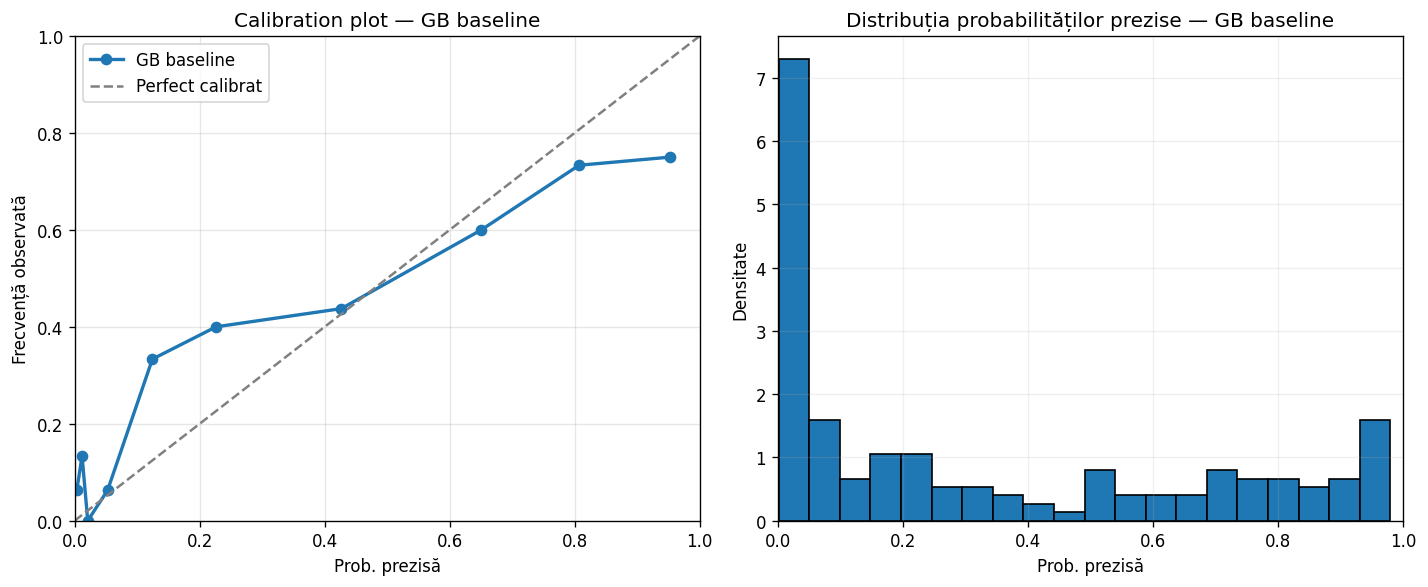

In [ ]:
prob_true_gb, prob_pred_gb = calibration_curve(
    y_test, proba_gb_base, n_bins=10, strategy="quantile"
)
brier_gb = brier_score_loss(y_test, proba_gb_base)

# ECE pe aceleași bin-uri (quantile)
q = np.linspace(0, 1, 11)
edges = np.quantile(proba_gb_base, q)
bin_idx = np.digitize(proba_gb_base, edges[1:-1], right=True)  # 0..9

ece_terms = []
for b in range(10):
    m = (bin_idx == b)
    if m.sum() == 0:
        continue
    conf = proba_gb_base[m].mean()
    acc  = y_test[m].mean()
    ece_terms.append(m.mean() * abs(acc - conf))
ece_gb = float(np.sum(ece_terms))

print(f"[GB baseline] Brier score (TEST): {brier_gb:.4f}")
print(f"[GB baseline] ECE (quantile bins): {ece_gb:.4f}\n")

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Calibration plot
axes[0].plot(prob_pred_gb, prob_true_gb, marker='o', linewidth=2, label="GB baseline")
axes[0].plot([0,1],[0,1],'--', color='gray', label="Perfect calibrat")
axes[0].set_xlim(0,1); axes[0].set_ylim(0,1)
axes[0].set_xlabel("Prob. prezisă"); axes[0].set_ylabel("Frecvență observată")
axes[0].set_title("Calibration plot — GB baseline")
axes[0].legend(loc="upper left"); axes[0].grid(alpha=0.3)

# Histogramă (densitate)
axes[1].hist(proba_gb_base, bins=20, edgecolor='k', density=True)
axes[1].set_xlim(0,1); axes[1].set_xlabel("Prob. prezisă"); axes[1].set_ylabel("Densitate")
axes[1].set_title("Distribuția probabilităților prezise — GB baseline")
axes[1].grid(alpha=0.2)

plt.tight_layout(); plt.show()


Importanța variabilelor

,importanta
Glucose,0.3764
BMI,0.1968
DiabetesPedigreeFunction,0.1239
Age,0.1142
Insulin,0.0814
Pregnancies,0.0607
BloodPressure,0.0236
SkinThickness,0.0231


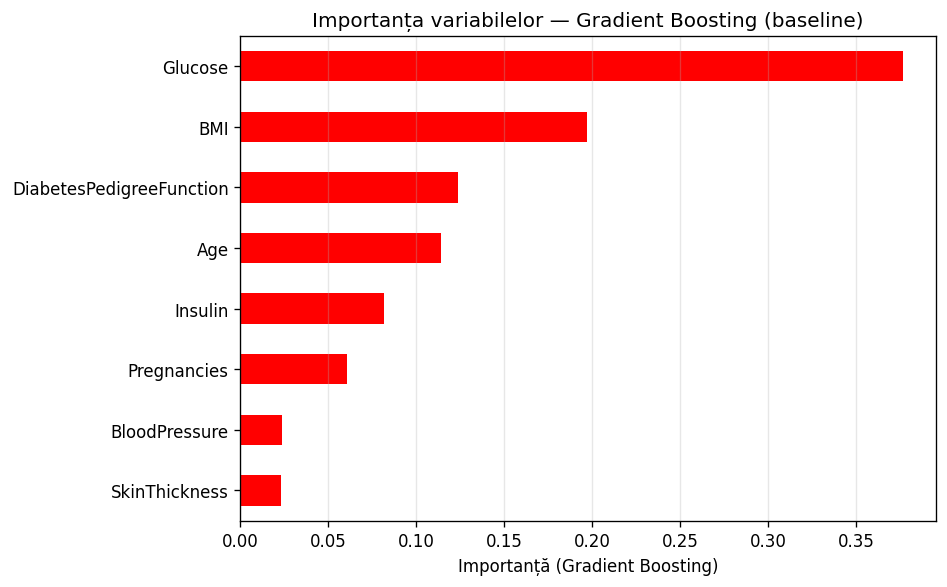

In [ ]:
imp_gb_base = pd.Series(gb_base.feature_importances_, index=feature_names)

interpretare_gb_base = (
    pd.DataFrame({
        "importanta": imp_gb_base
    })
    .reindex(imp_gb_base.sort_values(ascending=False).index)
    .round(4)
)

display(interpretare_gb_base)

plt.figure(figsize=(8,5))
valori_gb_base = interpretare_gb_base["importanta"].iloc[::-1]
valori_gb_base.plot(kind="barh", color="red")

plt.xlabel("Importanță (Gradient Boosting)")
plt.title("Importanța variabilelor — Gradient Boosting (baseline)")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


Gradient Boosting îmbunătățit: SMOTE + RandomizedSearch

In [ ]:
# folosim X_train_tr, y_train_tr (după SMOTE)

param_dist_gb = {
    "n_estimators":   [100, 200, 300],
    "learning_rate":  [0.01, 0.05, 0.1, 0.2],
    "max_depth":      [2, 3, 4],
    "subsample":      [0.7, 0.9, 1.0]
}

cv_gb = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

gb_base_model = GradientBoostingClassifier(random_state=RANDOM_STATE)

rand_gb = RandomizedSearchCV(
    gb_base_model,
    param_distributions=param_dist_gb,
    n_iter=25,
    scoring="accuracy",
    cv=cv_gb,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

rand_gb.fit(X_train_tr, y_train_tr)

print("Best params GB:", rand_gb.best_params_,
      "| CV acc:", round(rand_gb.best_score_, 4))

gb_best = rand_gb.best_estimator_
gb_best.fit(X_train_tr, y_train_tr)

proba_gb_best = gb_best.predict_proba(X_test_scl)[:, 1]

print("=== GB + SMOTE (tuned, thr=0.5) ===")
m_gb_best = eval_binary(y_test, proba_gb_best, 0.5, "GB Tuned + SMOTE")


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best params GB: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1} | CV acc: 0.8038
=== GB + SMOTE (tuned, thr=0.5) ===
GB Tuned + SMOTE
Accuracy=0.7273  Precision=0.5968  Recall=0.6852  F1=0.6379  AUC=0.8096
              precision    recall  f1-score   support

           0     0.8152    0.7500    0.7812       100
           1     0.5968    0.6852    0.6379        54

    accuracy                         0.7273       154
   macro avg     0.7060    0.7176    0.7096       154
weighted avg     0.7386    0.7273    0.7310       154

Confusion matrix:
 [[75 25]
 [17 37]]


ROC & PR – comparație GB Baseline vs GB Tuned

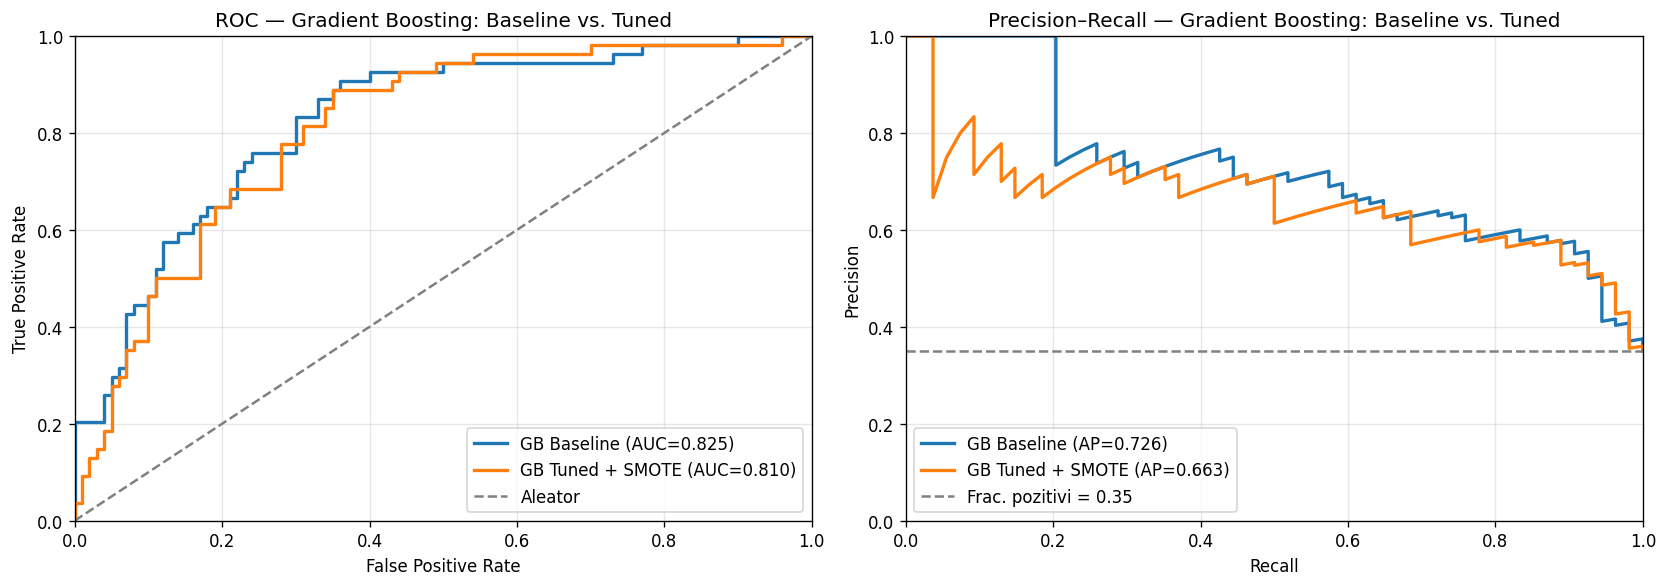

In [ ]:
models_proba_gb = {
    "GB Baseline": proba_gb_base,
    "GB Tuned + SMOTE": proba_gb_best
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC
ax = axes[0]
for name, proba in models_proba_gb.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    ax.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC={auc:.3f})")

ax.plot([0, 1], [0, 1], "--", color="gray", label="Aleator")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC — Gradient Boosting: Baseline vs. Tuned")
ax.legend(loc="lower right")
ax.grid(alpha=0.3)

# Precision–Recall
ax = axes[1]
baseline = y_test.mean()

for name, proba in models_proba_gb.items():
    prec, rec, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    ax.plot(rec, prec, linewidth=2, label=f"{name} (AP={ap:.3f})")

ax.plot([0, 1], [baseline, baseline], "--", color="gray",
        label=f"Frac. pozitivi = {baseline:.2f}")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision–Recall — Gradient Boosting: Baseline vs. Tuned")
ax.legend(loc="lower left")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


Comparație numerică GB Baseline vs GB Tuned

,Accuracy,Precision,Recall,F1,ROC AUC
GB Baseline,0.7597,0.6667,0.6296,0.6476,0.8254
GB Tuned + SMOTE,0.7273,0.5968,0.6852,0.6379,0.8096


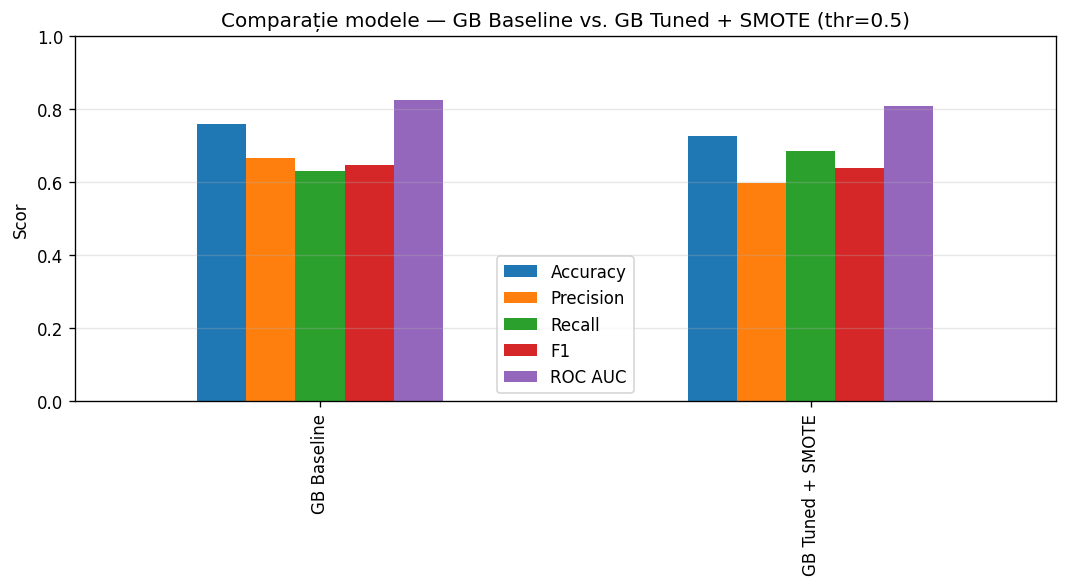

In [ ]:
acc_b_gb  = m_gb_base["acc"];  prec_b_gb = m_gb_base["prec"];  rec_b_gb = m_gb_base["rec"];  f1_b_gb = m_gb_base["f1"];  auc_b_gb = m_gb_base["auc"]
acc_t_gb  = m_gb_best["acc"];  prec_t_gb = m_gb_best["prec"];  rec_t_gb = m_gb_best["rec"];  f1_t_gb = m_gb_best["f1"];  auc_t_gb = m_gb_best["auc"]

comparatie_gb = pd.DataFrame({
    "Accuracy":  [acc_b_gb,  acc_t_gb],
    "Precision": [prec_b_gb, prec_t_gb],
    "Recall":    [rec_b_gb,  rec_t_gb],
    "F1":        [f1_b_gb,   f1_t_gb],
    "ROC AUC":   [auc_b_gb,  auc_t_gb],
}, index=["GB Baseline", "GB Tuned + SMOTE"]).round(4)

display(comparatie_gb)

ax = comparatie_gb.plot(kind="bar", figsize=(9,5))
plt.title("Comparație modele — GB Baseline vs. GB Tuned + SMOTE (thr=0.5)")
plt.ylabel("Scor"); plt.ylim(0,1)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout(); plt.show()


Learning Curve — Gradient Boosting

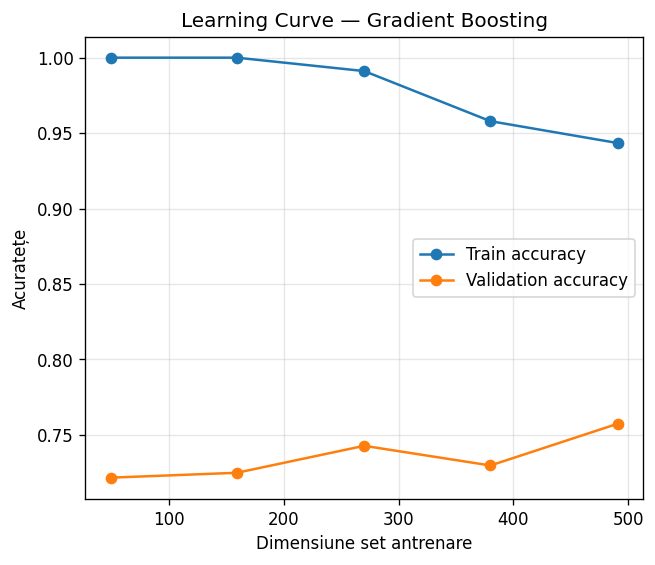

In [ ]:
train_sizes_gb, train_scores_gb, val_scores_gb = learning_curve(
    GradientBoostingClassifier(random_state=RANDOM_STATE),
    X_train_scl,
    y_train,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean_gb = train_scores_gb.mean(axis=1)
val_mean_gb   = val_scores_gb.mean(axis=1)

plt.figure(figsize=(6,5))
plt.plot(train_sizes_gb, train_mean_gb, 'o-', label="Train accuracy")
plt.plot(train_sizes_gb, val_mean_gb,   'o-', label="Validation accuracy")
plt.xlabel("Dimensiune set antrenare")
plt.ylabel("Acuratețe")
plt.title("Learning Curve — Gradient Boosting")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Histogramă predicții per clasă — GB Tuned

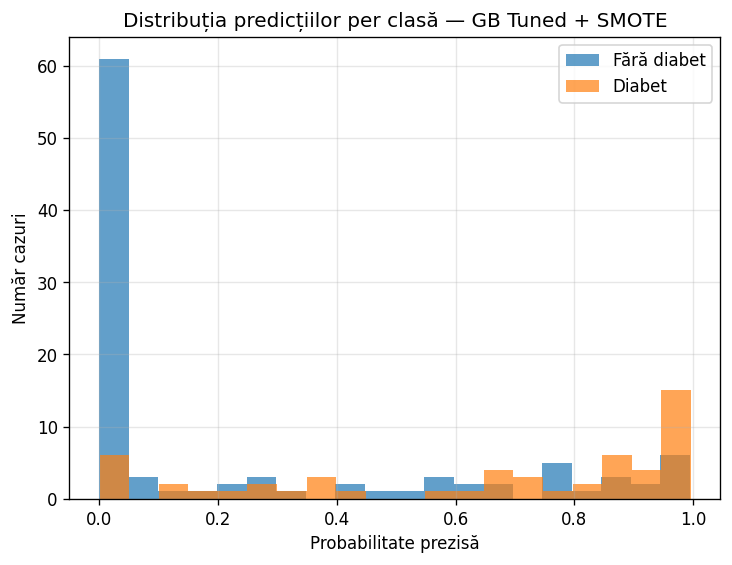

In [ ]:
plt.figure(figsize=(7,5))
plt.hist(proba_gb_best[y_test==0], bins=20, alpha=0.7, label="Fără diabet")
plt.hist(proba_gb_best[y_test==1], bins=20, alpha=0.7, label="Diabet")
plt.xlabel("Probabilitate prezisă")
plt.ylabel("Număr cazuri")
plt.title("Distribuția predicțiilor per clasă — GB Tuned + SMOTE")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Prag optim pe valid (max F1) și aplicare pe test — GB

In [ ]:
# split valid din TRAIN original (fără scurgere din TEST)
X_tr_sub_gb, X_val_gb, y_tr_sub_gb, y_val_gb = train_test_split(
    X_train_raw, y_train, test_size=0.2, stratify=y_train, random_state=RANDOM_STATE
)

# preproc pe sub-train
imp_val_gb = SimpleImputer(strategy="median"); sc_val_gb = StandardScaler()
X_tr_sub_imp_gb = imp_val_gb.fit_transform(X_tr_sub_gb); X_val_imp_gb = imp_val_gb.transform(X_val_gb)
X_tr_sub_scl_gb = sc_val_gb.fit_transform(X_tr_sub_imp_gb); X_val_scl_gb = sc_val_gb.transform(X_val_imp_gb)

# SMOTE pe sub-train
sm_val_gb = SMOTE(random_state=RANDOM_STATE)
X_tr_sub_tr_gb, y_tr_sub_tr_gb = sm_val_gb.fit_resample(X_tr_sub_scl_gb, y_tr_sub_gb)

# re-antrenare GB pe sub-train echilibrat
gb_val = GradientBoostingClassifier(
    n_estimators=gb_best.n_estimators,
    learning_rate=gb_best.learning_rate,
    max_depth=gb_best.max_depth,
    subsample=gb_best.subsample,
    random_state=RANDOM_STATE
)
gb_val.fit(X_tr_sub_tr_gb, y_tr_sub_tr_gb)
proba_val_gb = gb_val.predict_proba(X_val_scl_gb)[:, 1]

# best threshold (max F1)
prec_v_gb, rec_v_gb, thr_v_gb = precision_recall_curve(y_val_gb, proba_val_gb)
f1_v_gb = 2 * (prec_v_gb * rec_v_gb) / (prec_v_gb + rec_v_gb + 1e-12)
ix_gb = int(np.nanargmax(f1_v_gb))
best_thr_gb = thr_v_gb[ix_gb] if ix_gb < len(thr_v_gb) else 0.5
print(f"[GB] Prag optim (max F1) pe VALIDARE: {best_thr_gb:.4f} | Precision={prec_v_gb[ix_gb]:.4f} Recall={rec_v_gb[ix_gb]:.4f} F1={f1_v_gb[ix_gb]:.4f}")

# aplicăm pragul pe modelul GB Tuned + SMOTE (deja antrenat pe tot train-ul)
pred_test_opt_gb = (proba_gb_best >= best_thr_gb).astype(int)
print("\nEvaluare GB Tuned + SMOTE cu pragul optim:")
print(classification_report(y_test, pred_test_opt_gb, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, pred_test_opt_gb))


[GB] Prag optim (max F1) pe VALIDARE: 0.4890 | Precision=0.6327 Recall=0.7209 F1=0.6739

Evaluare GB Tuned + SMOTE cu pragul optim:
              precision    recall  f1-score   support

           0     0.8152    0.7500    0.7812       100
           1     0.5968    0.6852    0.6379        54

    accuracy                         0.7273       154
   macro avg     0.7060    0.7176    0.7096       154
weighted avg     0.7386    0.7273    0.7310       154

Confusion matrix:
 [[75 25]
 [17 37]]


SHAP values — GB Tuned + SMOTE

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipython-input-257991363.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


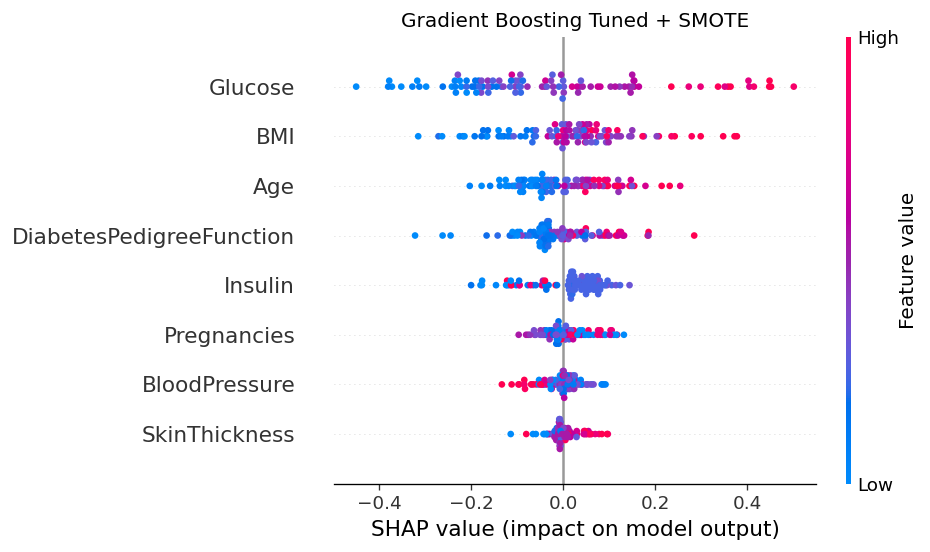

In [ ]:
shap.initjs()
# background: subset din X_train_tr (după SMOTE + scalare)
bg_size_gb = min(100, X_train_tr.shape[0])
background_gb = X_train_tr[:bg_size_gb]

# funcția de model: probabilitatea clasei 1 (diabet)
f_gb = lambda X: gb_best.predict_proba(X)[:, 1]

explainer_gb_opt = shap.KernelExplainer(f_gb, background_gb)

# subset din test
n_samples_gb = min(100, X_test_scl.shape[0])
X_test_sample_gb = X_test_scl[:n_samples_gb]

shap_values_gb_opt = explainer_gb_opt.shap_values(X_test_sample_gb)

plt.title("Gradient Boosting Tuned + SMOTE")
shap.summary_plot(
    shap_values_gb_opt,
    X_test_sample_gb,
    feature_names=feature_names,
    show=True
)
